In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import sqlite3
from pathlib import Path
from lmfit.models import LinearModel
from lmfit import Parameters, minimize, report_fit
import statsmodels.formula.api as smf
from scipy import constants

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams["lines.linewidth"] = 0.5
mpl.rcParams["axes.linewidth"] = 0.5

mpl.rcParams.update({
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.5,
    "ytick.minor.width": 0.5,
})

# set font size
mpl.rcParams.update({'font.size': 7})

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

In [2]:
def calculate_r2_from_fit(merged_dG, x_col = 'dG', y_col = 'dG_imino', x_label = 'DMS', y_label = 'NMR'):
    linear_model = LinearModel()
    params = linear_model.guess(merged_dG[y_col], x=merged_dG[x_col])
    result = linear_model.fit(merged_dG[y_col], params, x=merged_dG[x_col])

    # calculate r2
    r2 = result.rsquared
    return r2

def plot_linear_correlation(
    merged_dG,
    x_col='dG',
    y_col='dG_imino',
    x_err_col='dG_err',
    y_err_col='dG_err_imino',
    x_label='DMS',
    y_label='NMR',
    construct='4U',
    temp=20,
):
    linear_model = LinearModel()
    params = linear_model.guess(merged_dG[y_col], x=merged_dG[x_col])
    result = linear_model.fit(merged_dG[y_col], params, x=merged_dG[x_col])

    print(result.fit_report())

    fig, ax = plt.subplots(figsize=(2, 2))
    ax.scatter(merged_dG[x_col], merged_dG[y_col], color='black', s=8)
    ax.plot(merged_dG[x_col], result.best_fit, color='black', linewidth=1)

    # ---- plot errors only if requested ----
    plot_xerr = x_err_col not in (None, 'none')
    plot_yerr = y_err_col not in (None, 'none')

    if plot_xerr or plot_yerr:
        for i in range(len(merged_dG)):
            x = merged_dG[x_col].iloc[i]
            y = merged_dG[y_col].iloc[i]

            x_err = merged_dG[x_err_col].iloc[i] if plot_xerr else None
            y_err = merged_dG[y_err_col].iloc[i] if plot_yerr else None

            ax.errorbar(
                x, y,
                xerr=x_err,
                yerr=y_err,
                fmt='none',
                color='black',
                capsize=1,
                elinewidth=0.5,
            )

    label = r'$\Delta G_{XXX, TTT^\circ\mathrm{C}}$ (kcal/mol)'
    label = label.replace('TTT', str(temp))
    ax.set_xlabel(label.replace('XXX', x_label))
    ax.set_ylabel(label.replace('XXX', y_label))

    if x_label == 'endpt':
        ax.set_xlabel('ln(Mut. Rate)')
    elif x_label == 'endpt2':
        ax.set_xlabel('Pseudo-free energy (kcal/mol)')
    if y_label == 'endpt':
        ax.set_ylabel('ln(Mut. Rate)')
    elif y_label == 'endpt2':
        ax.set_ylabel('Pseudo-free energy (kcal/mol)')

    # ax.set_ylim(1, 5)

    r2 = result.rsquared
    ax.annotate(
        f'$R^2$ = {r2:.2f}',
        xy=(0.95, 0.05),
        xycoords='axes fraction',
        fontsize=9,
        ha='right',
        va='bottom',
    )

    plt.tight_layout()
    plt.savefig(f'{construct}_{y_label}_v_{x_label}.pdf')
    print(f'Saving figure as {construct}_{y_label}_v_{x_label}.pdf')
    plt.show()

In [3]:
# NMR imino energies
nmr_energies_wt = pd.read_csv('NMR_imino/fourU_imino_ref_WT_Rinnenthal2011_processed.csv')
nmr_energies_wt['disp_name'] = '4U_wt'
nmr_energies_a8c = pd.read_csv('NMR_imino/fourU_imino_ref_A8C_Rinnenthal2011_processed.csv')
nmr_energies_a8c['disp_name'] = '4U_a8c'
nmr_energies = pd.concat([nmr_energies_wt, nmr_energies_a8c], ignore_index=True)

# NN-based energies (ensemble)
nn_energies_wt = pd.read_csv('NNensemble/fourU/WT_25C.csv')
nn_energies_wt['disp_name'] = '4U_wt'
nn_energies_a8c = pd.read_csv('NNensemble/fourU/A8C_25C.csv')
nn_energies_a8c['disp_name'] = '4U_a8c'
nn_energies = pd.concat([nn_energies_wt, nn_energies_a8c], ignore_index=True)

# PRIME-dG energies
prime_energies = pd.read_csv('PRIME-dG/4U_energy_with18A_25C.csv')

# reactivities (fmod_15min, ln_reactivity_15min, fmod_infinity, ln_reactivity_infinity)
raw_fmod_a8c = pd.read_csv('reactivity_and_derivatives/ln_reactivity_25C_4U_a8c.csv')
raw_fmod_a8c['disp_name'] = '4U_a8c'
raw_fmod_wt = pd.read_csv('reactivity_and_derivatives/ln_reactivity_25C_4U_wt.csv')
raw_fmod_wt['disp_name'] = '4U_wt'
raw_fmod = pd.concat([raw_fmod_wt, raw_fmod_a8c], ignore_index=True)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 16
    # variables        = 2
    chi-square         = 2.41062661
    reduced chi-square = 0.17218762
    Akaike info crit   = -26.2832321
    Bayesian info crit = -24.7380546
    R-squared          = 0.74728545
[[Variables]]
    slope:      0.30310596 +/- 0.04710883 (15.54%) (init = 0.303106)
    intercept:  1.14694623 +/- 0.23948245 (20.88%) (init = 1.146946)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9013
Saving figure as 4U_PRIME_v_NMR.pdf


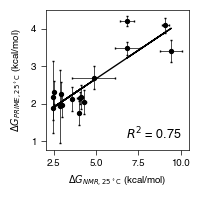

In [4]:
prime_v_nmr = pd.merge(prime_energies, nmr_energies, on=['site', 'disp_name'], suffixes=('_prime', '_nmr'))
calculate_r2_from_fit(prime_v_nmr, x_col='dG_prime', y_col='dG_calc_25')

plot_linear_correlation(
    prime_v_nmr,
    y_col='dG_prime',
    y_err_col='dG_err_prime',
    x_col='dG_nmr',
    x_err_col='dG_err_nmr',
    y_label='PRIME',
    x_label='NMR',
    construct='4U',
    temp=25,
)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 24
    # variables        = 2
    chi-square         = 3.95672377
    reduced chi-square = 0.17985108
    Akaike info crit   = -39.2632995
    Bayesian info crit = -36.9071918
    R-squared          = 0.84782576
[[Variables]]
    slope:      0.44183636 +/- 0.03990868 (9.03%) (init = 0.4418364)
    intercept:  0.46184368 +/- 0.16404758 (35.52%) (init = 0.4618437)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.8494
Saving figure as 4U_PRIME_v_NN.pdf


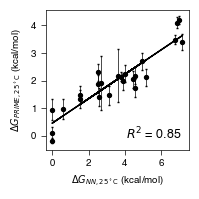

In [5]:
prime_v_nn = pd.merge(prime_energies, nn_energies, on=['site', 'disp_name'], suffixes=('_prime', '_nn'))

plot_linear_correlation(
    prime_v_nn,
    y_col='dG_prime',
    y_err_col='dG_err',
    x_col='dG_nn',
    x_err_col=None,
    x_label='NN',
    y_label='PRIME',
    construct='4U',
    temp=25,
)


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 16
    # variables        = 2
    chi-square         = 6.18903328
    reduced chi-square = 0.44207381
    Akaike info crit   = -11.1969571
    Bayesian info crit = -9.65177970
    R-squared          = 0.83541619
[[Variables]]
    slope:      0.63631279 +/- 0.07548293 (11.86%) (init = 0.6363128)
    intercept:  1.73761022 +/- 0.38372503 (22.08%) (init = 1.73761)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9013


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Saving figure as 4U_NN_v_NMR.pdf


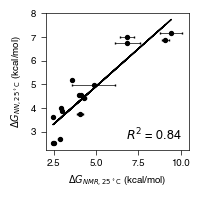

In [6]:
nmr_v_nn = pd.merge(nmr_energies, nn_energies, on=['site', 'disp_name'], suffixes=('_nmr', '_nn'))

plot_linear_correlation(
    nmr_v_nn,
    x_col='dG_nmr',
    x_err_col='dG_err',
    y_col='dG_nn',
    y_err_col=None,
    x_label='NMR',
    y_label='NN',
    construct='4U',
    temp=25,
)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 13
    # variables        = 2
    chi-square         = 2.34347246
    reduced chi-square = 0.21304295
    Akaike info crit   = -18.2731024
    Bayesian info crit = -17.1432037
    R-squared          = 9.6319e-04
[[Variables]]
    slope:     -0.01112700 +/- 0.10804798 (971.04%) (init = -0.011127)
    intercept: -6.33686051 +/- 0.41863804 (6.61%) (init = -6.336861)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9521
Saving figure as 4U_endpt_v_NMR.pdf


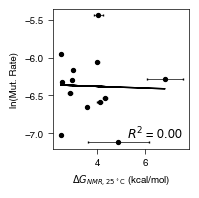

In [14]:
nmr_v_reactivities = pd.merge(nmr_energies, raw_fmod, on=['site', 'disp_name'], suffixes=('_nmr', '_reactivity'))

plot_linear_correlation(
    nmr_v_reactivities,
    x_col='dG',
    x_err_col='dG_err',
    y_col='ln_reactivity_15min',
    y_err_col=None,
    x_label='NMR',
    y_label='endpt',
    construct='4U',
    temp=25,
)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 21
    # variables        = 2
    chi-square         = 3.45381406
    reduced chi-square = 0.18177969
    Akaike info crit   = -33.9059092
    Bayesian info crit = -31.8168643
    R-squared          = 0.74232054
[[Variables]]
    slope:     -126.724883 +/- 17.1288917 (13.52%) (init = -126.7249)
    intercept:  2.34223232 +/- 0.12407297 (5.30%) (init = 2.342232)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.6616
Saving figure as 4U_PRIME_v_Reactivity.pdf


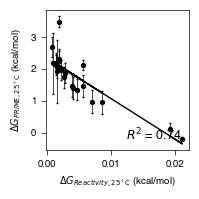

In [8]:
prime_v_reactivities = pd.merge(prime_energies, raw_fmod, on=['site', 'disp_name'], suffixes=('_prime', '_reactivity'))

# (fmod_15min, ln_reactivity_15min, fmod_infinity, ln_reactivity_infinity)

plot_linear_correlation(
    prime_v_reactivities,
    y_col='dG',
    y_err_col='dG_err',
    x_col='fmod_15min',
    x_err_col=None,
    x_label='Reactivity',
    y_label='PRIME',
    construct='4U',
    temp=25,
)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 21
    # variables        = 2
    chi-square         = 3.30981080
    reduced chi-square = 0.17420057
    Akaike info crit   = -34.8002596
    Bayesian info crit = -32.7112148
    R-squared          = 0.75306422
[[Variables]]
    slope:     -0.79513689 +/- 0.10445786 (13.14%) (init = -0.7951369)
    intercept: -2.90027224 +/- 0.61570606 (21.23%) (init = -2.900272)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = +0.9890
Saving figure as 4U_PRIME_v_Reactivity.pdf


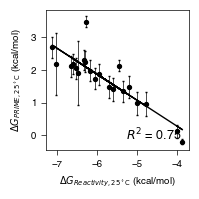

In [10]:
plot_linear_correlation(
    prime_v_reactivities,
    y_col='dG',
    y_err_col='dG_err',
    x_col='ln_reactivity_15min',
    x_err_col=None,
    x_label='Reactivity',
    y_label='PRIME',
    construct='4U',
    temp=25,
)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 21
    # variables        = 2
    chi-square         = 1.89526335
    reduced chi-square = 0.09975070
    Akaike info crit   = -46.5084574
    Bayesian info crit = -44.4194126
    R-squared          = 0.85859967
[[Variables]]
    slope:     -0.72380175 +/- 0.06738647 (9.31%) (init = -0.7238017)
    intercept: -1.66112073 +/- 0.32360049 (19.48%) (init = -1.661121)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = +0.9771
Saving figure as 4U_PRIME_v_Reactivity.pdf


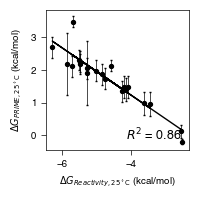

In [12]:
plot_linear_correlation(
    prime_v_reactivities,
    y_col='dG',
    y_err_col='dG_err',
    x_col='ln_reactivity_infinity',
    x_err_col=None,
    x_label='Reactivity',
    y_label='PRIME',
    construct='4U',
    temp=25,
)
